# Model training

## Load Python packages

In [1]:
import numpy as np
from scipy import stats
import session_info
import pdb
from sklearn.metrics import r2_score
import shutil
import pandas as pd
import re
import os
from Bio.Seq import Seq
import gc
import matplotlib.pyplot as plt
import datetime
import socket
import time
import json
from collections import OrderedDict
import random as python_random

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn.parameter import Parameter
import math
import pickle as pk
import sys

## Parameters

In [3]:
RUNTIME = 'none'
ARGS = {
  'model_id' : 'm20220727e',
  'global_seed' : 123,
  'shuffle_size' : 1000,
  'max_width' : 100,
  'head_len' : 17,
  'tail_len' : 13,
  'pct_ds' : 1, # % of total data for training/testing,
  'train_split' : 0.95,
  'alphabets' : {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3, 'N' : 4, 'M' : 5},
  'initial_lr' : 1e-15,
  'max_lr' : 3e-4,
  'initial_epoch': 0,
  'epochs' : 20,
  'batch_size' : 512,
  'dropout_rate' : 0.1,
  'kmer': 10,
  'strides' : 1,
  'embedding_dim' : 512,
  'num_heads' : 8,
  'ff_mult' : 4,
  'num_projectors' : 32,
  'n_blocks_regressor' : 4,
  'warmup_steps' : 12500, # ~ 1 epoch
  'mask_ratio' : 0.05,
  'remote_sample_submission_file' : 'https://raw.githubusercontent.com/de-Boer-Lab/DREAM-2022/main/sample_submission.json',
  'eval' : False,
  'device':'cuda:1'
}
if RUNTIME == 'msi':
  ARGS['remote_data_dir'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/training_data/pct_ds=' + str(ARGS['pct_ds']) + '/'
  ARGS['local_data_dir'] = re.sub('https://', './', ARGS['remote_data_dir'])
  ARGS['remote_checkpoint_dir'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/notebooks_msi/' + ARGS['model_id'] + '/tf_ckpts/'
  ARGS['remote_log_dir'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/notebooks_msi/' + ARGS['model_id'] + '/log/'
  ARGS['local_checkpoint_dir'] = re.sub('https://', './', ARGS['remote_checkpoint_dir'])
  ARGS['local_log_dir'] = re.sub('https://', './', ARGS['remote_log_dir'])
  ARGS['remote_test_data'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/test_sequences.txt.gz'
  ARGS['local_test_data'] = re.sub('https://', './', ARGS['remote_test_data'])
  ARGS['local_sample_submission_file'] = re.sub('https://', './', ARGS['remote_sample_submission_file'])
  ARGS['remote_prediction_file'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/predictions/' + ARGS['model_id'] + '/pred.json'
  ARGS['local_prediction_file'] = re.sub('https://', './', ARGS['remote_prediction_file'])
  ARGS['s3_prediction_file'] = re.sub('https://s3.msi.umn.edu', 's3://', ARGS['remote_prediction_file'])
  ARGS['remote_prediction_tsv_file'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/predictions/' + ARGS['model_id'] + '/pred.tsv'
  ARGS['local_prediction_tsv_file'] = re.sub('https://', './', ARGS['remote_prediction_tsv_file'])
  ARGS['s3_prediction_tsv_file'] = re.sub('https://s3.msi.umn.edu', 's3://', ARGS['remote_prediction_tsv_file'])
else:
  ARGS['local_data_dir'] = '/content/drive/MyDrive/training_data/pct_ds=' + str(ARGS['pct_ds']) + '/'
  ARGS['local_checkpoint_dir'] = '/content/drive/MyDrive/' + ARGS['model_id'] + '/tf_ckpts/'
  ARGS['local_log_dir'] = '/content/drive/MyDrive/' + ARGS['model_id'] + '/log/'

In [4]:
ARGS['local_data_dir'] = '/Data1/PGE/torch_ti/data/'

In [5]:
with open(ARGS['local_data_dir']+"data.pk","rb") as fr:
    data = pk.load(fr)

### Set seeds

In [6]:
np.random.seed(ARGS['global_seed'])
torch.manual_seed(ARGS['global_seed'])
python_random.seed(ARGS['global_seed'])

### pearson_r

In [7]:
def pearson_r(x, y):
    x = torch.tensor(x,dtype=torch.float32)
    y = torch.tensor(y,dtype=torch.float32)
    mx = torch.mean(x, axis = 0, keepdims = True)
    my = torch.mean(y, axis = 0, keepdims = True)
    xm = x - mx
    ym = y - my
    t1_norm = F.normalize(xm, p=2, dim=0)
    t2_norm = F.normalize(ym, p=2, dim=0)
    return torch.sum(torch.mul(t1_norm, t2_norm))

In [8]:
x = np.random.rand(100)
y = np.random.rand(100)
print('pearson r (stats.pearsonr): {}'.format(stats.pearsonr(x, y)[0]))
print('pearson r (pearson_r): {}'.format(pearson_r(torch.unsqueeze(torch.Tensor(x),1), torch.unsqueeze(torch.Tensor(y),1))))

pearson r (stats.pearsonr): -0.09270195576139686
pearson r (pearson_r): -0.09270194172859192


/tmp/ipykernel_10275/2976460682.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)
/tmp/ipykernel_10275/2976460682.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y,dtype=torch.float32)


### GLULayer

In [9]:
class GLULayer(nn.Module):
    def __init__(self, dim):
        super(GLULayer, self).__init__()
        self.dim = dim
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out,gate = torch.chunk(x, 2, dim = self.dim)
        return out * self.sig(gate)

In [10]:
layer = GLULayer(dim = 1)
x = torch.randn(3,6,10)
layer(x).shape

torch.Size([3, 3, 10])

### SwiGLU

In [11]:

class SwiGLULayer(nn.Module):
    def __init__(self, dim):
        super(SwiGLULayer, self).__init__()
        self.dim = dim
        self.swish = nn.SiLU() # same as swish

    def forward(self, x):
        out, gate = torch.chunk(x, 2, dim = self.dim)
        return out * self.swish(gate)

In [12]:
layer = SwiGLULayer(dim = 1)
x = torch.randn(3,6,10)
layer(x).shape

torch.Size([3, 3, 10])

### FeedForwardSwiGLU

In [13]:

class FeedForwardSwiGLU(nn.Module):
    def __init__(self, embedding_dim, mult=4, rate = 0.0, use_bias = False):
        super(FeedForwardSwiGLU, self).__init__()
        swiglu_out = int(embedding_dim * mult/2)
        self.layernorm = nn.LayerNorm(embedding_dim,eps = 1e-6)
        self.linear1 = nn.Linear(embedding_dim,embedding_dim * mult, bias = use_bias)
        self.swiglulayer = SwiGLULayer(dim = 1)
        self.drop = nn.Dropout(rate)
        self.linear2 = nn.Linear(swiglu_out,embedding_dim, bias = use_bias)

    def forward(self, inputs):
        x = self.layernorm(inputs.transpose(1,2)) # 차원바뀌고 채널 dim=2
        x = self.linear1(x) 
        x = self.swiglulayer(x.transpose(1,2)) # 또 차원 바뀌고 채널 dim =1
        x = self.drop(x)
        x = self.linear2(x.transpose(1,2)) # 차원 바뀌고 채널 dim=2
        out = self.drop(x.transpose(1,2)) # 차원 또 바뀌고 채널 dim =1
        return out

In [14]:
ffn = FeedForwardSwiGLU(embedding_dim = 5, mult = 4)
x = torch.randn(3,5,10)
print(ffn(x).shape)

torch.Size([3, 5, 10])


### CustomSchedule

In [19]:
n_train = 6400689
model = FeedForwardSwiGLU(embedding_dim = 5, mult = 4)
optim           = torch.optim.Adam(model.parameters(), lr = ARGS['initial_lr'], betas=(0.9, 0.98), eps=1e-08)
scheduler       = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=ARGS['max_lr'],pct_start = 0.1, 
                                                                   steps_per_epoch=int(n_train/ARGS['batch_size'])+1, epochs=ARGS['epochs'],anneal_strategy='cos')


Text(0.5, 1.0, 'OneCycleLR Scheduler')

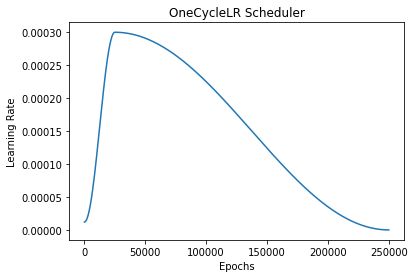

In [20]:
lrs  = []
for  i  in  range(250000):
	scheduler.step()
	lrs.append(optim.param_groups[0]["lr"])  

plt.plot(lrs)
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("OneCycleLR Scheduler")

### ConformerSASwiGLULayer

In [17]:


class ConformerSASwiGLULayer(nn.Module):
    def __init__(self, embedding_dim,  ff_mult = 4, kernel_size = 15, rate = 0.2, num_heads = 4, use_bias = False):
        super(ConformerSASwiGLULayer, self).__init__()
        self.ff1 = FeedForwardSwiGLU(embedding_dim = embedding_dim, mult = ff_mult, rate = rate, use_bias = use_bias)
        self.layernorm1 = nn.LayerNorm(embedding_dim,eps = 1e-6)
        self.conv = nn.Sequential(   
          nn.Conv1d(in_channels=embedding_dim, out_channels=embedding_dim, kernel_size=kernel_size, groups=embedding_dim, padding='same'),
          nn.Conv1d(in_channels=embedding_dim, out_channels=embedding_dim, kernel_size=1, padding='same'),
          nn.ReLU(),
          nn.Dropout(rate),
        )
        self.layernorm2 = nn.LayerNorm(embedding_dim,eps = 1e-6)    
        self.attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads,batch_first=True)
        self.ff2 = FeedForwardSwiGLU(embedding_dim = embedding_dim, mult = ff_mult, rate = rate, use_bias = use_bias)

    def forward(self, x):
        x = x.float()
        x = x + 0.5 * self.ff1(x)
        x = self.layernorm1(x.transpose(1,2)) #채널 dim = 2
        x = x + self.conv(x.transpose(1, 2)).transpose(1, 2) # output 채널 dim = 2
        x = self.layernorm2(x)
        x = x + self.attn(x, x, x)[0]
        x = x.transpose(1,2) + 0.5 * self.ff2(x.transpose(1,2))
        return x

In [18]:
layer = ConformerSASwiGLULayer(embedding_dim = 16)
x = torch.randn(3,16,10)
print(layer(x).shape)

torch.Size([3, 16, 10])


### SequenceMaskLayer

In [19]:
class SequenceMaskLayer(nn.Module):
    def __init__(self, n_positions, ratio = 0.2):
        super(SequenceMaskLayer, self).__init__()
        self.ratio = ratio
        self.n_positions = n_positions
        self.N = 4
        self.M = 5

    def forward(self, x):

        if self.ratio > 0:
            m = torch.rand(x.shape) < self.ratio
            m = m*1
            is_valid = x == self.N
            is_valid = is_valid * 1
            m = m * is_valid
            x0 = torch.ones(x.shape) * self.M

            x = m * x0 + (1 - m) * x
            m = m.float()
        else:
            m = torch.zeros(x.shape)
    
        return x, m

In [20]:
layer = SequenceMaskLayer(n_positions = 20, ratio = 0.2)
x = torch.rand([3,20])*5
x = torch.floor(x)
x, m = layer(x)
print(x)
print(m)

tensor([[2., 0., 0., 0., 4., 4., 1., 0., 4., 1., 0., 2., 1., 1., 0., 4., 2., 0.,
         0., 3.],
        [0., 2., 2., 3., 3., 0., 1., 3., 1., 3., 4., 2., 1., 5., 5., 1., 1., 0.,
         2., 3.],
        [2., 1., 1., 1., 3., 1., 0., 1., 4., 3., 3., 2., 3., 4., 0., 4., 2., 1.,
         0., 2.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])


## Read data

In [21]:
input_dim = int(6) # A,C,G,T,N,M
#input_dim = int(5) # A,C,G,T,N
n_positions = ARGS['max_width'] * 2

In [22]:
n = int(len(data['seq']))
n_train = int(n * ARGS['train_split'])
print('downsampled dataset size: %d' % (n))
print('training dataset size: %d' % (n_train))

downsampled dataset size: 6737568
training dataset size: 6400689


In [23]:
train_data = {'seq':data['seq'][:n_train],'expression':data['expression'][:n_train]}
val_data = {'seq':data['seq'][n_train:],'expression':data['expression'][n_train:]}

print('# training samples: %d' % (len(train_data['seq'])))
print('# val samples: %d' % (len(val_data['seq'])))

# training samples: 6400689
# val samples: 336879


# DataLoader & TestSet Preprocessing

In [24]:
class train_loader(object):
    def __init__(self, data):
        self.data = data['seq']
        self.data_label = data['expression']

    def __getitem__(self, index):

        return torch.FloatTensor(self.data[index]), self.data_label[index] 
    
    def __len__(self):
        return len(self.data)

class test_loader(object):
    def __init__(self,args):
        lines = open("/Data1/PGE/torch_ti/filtered_test_data_with_MAUDE_expression.txt", "r").read().splitlines()
        data = [x.split('\t')[0] for x in lines]
        data_label = [x.split('\t')[1] for x in lines]
        df = pd.DataFrame()
        df['dna'] = data
        df['expression'] = data_label
        df['dna'] = df['dna'].astype('string')
        df['len'] = df['dna'].str.len()
        print('number of unique sequences in the first {} positions: {}'.format(args['head_len'], len(df['dna'].str[:args['head_len']].unique())))
        print('number of unique sequences in the last {} positions: {}'.format(args['tail_len'], len(df['dna'].str[-args['tail_len']:].unique())))
        df['dna'] = df['dna'].str[args['head_len']:]
        df['dna'] = df['dna'].str[:-args['tail_len']]
        df['len'] = df['dna'].str.len()
        assert all(df['len'] <= args['max_width'])
        
        df['dna'] = df['dna'].str.pad(width = args['max_width'], side = 'both', fillchar = 'N')
        df['dna'] = df['dna'] + df['dna'].apply(lambda x: str(Seq(x).reverse_complement())).astype('string')
        
        input_dim = int(6) # A,C,G,T,N,M
        n_positions = int(args['max_width'] * 2)
        self.dna = np.empty((0, n_positions), np.uint8)
        for x in np.array_split(df['dna'], 10): # split data into chunks
            y = np.array(x.apply(list))
            y = np.vstack(y)
            y = np.vectorize(ARGS['alphabets'].get)(y)
            y = y.astype(np.uint8)
            print(y.shape)
            self.dna = np.append(self.dna, y, axis = 0)
        print(self.dna.shape)
        self.expression = df['expression'].astype('float32').to_numpy()
        expression_std = np.std(self.expression)
        expression_mean = np.mean(self.expression)
        self.expression = (self.expression - expression_mean) / expression_std
        
        print(self.expression.shape)
        
        
    def __getitem__(self, index):

        return torch.FloatTensor(self.dna[index]), self.expression[index] 
    
    def __len__(self):
        return len(self.dna)

## The regressor

In [26]:
class FirstLayer_Block(nn.Module):
    def __init__(self, n_positions, kmer = 3, embedding_dim = 32, input_dim = 5, strides = 2, ratio = 0.2, ff_mult = 4, use_bias = False, num_projectors = 8):
        super(FirstLayer_Block, self).__init__()
        self.n_positions = int(n_positions / strides)
        self.input_dim = input_dim
        self.kmer = kmer
        self.strides = strides
        self.num_projectors = num_projectors
        
        self.masking = SequenceMaskLayer(n_positions = n_positions, ratio = ratio)
        self.pos_embedding = nn.Embedding(self.n_positions, embedding_dim)
        self.strand_embedding = nn.Embedding(2, embedding_dim) # plus/minus strands
        self.expression_embedding = nn.Linear(1,embedding_dim)
        self.kmer_dense = nn.Linear(input_dim*self.kmer,embedding_dim)
       


    def forward(self, x): # input = (batch, seq)

        batch_size = x.shape[0]

        x = F.one_hot(x.to(torch.int64), self.input_dim)   # output = (b,seq,embed)

        x = x.unsqueeze(2)  # b,seq,em,1
        x_shape = x.shape
        fold_shape = x.unfold(1,self.kmer,self.strides).transpose(3,4).shape
        div = x_shape[1] - fold_shape[1]
        x = F.pad(x.unfold(1,self.kmer,self.strides).transpose(3,4),(0,0,0,0,0,0,0,div),'constant',0).reshape(x.shape[0],x.shape[1]//self.strides,x.shape[2],-1)
        x = x.squeeze(2).float()
        x = self.kmer_dense(x)

        pos = torch.arange(start=0, end = self.n_positions, step=1).cuda()
        pos = pos.unsqueeze(0)
        pos = self.pos_embedding(pos.long())

        strand = torch.tensor(np.repeat([0,1], repeats = int(self.n_positions / 2))).cuda()
        strand = strand.unsqueeze(0)
        strand = self.strand_embedding(strand.long())

        x = x + pos + strand  # 채널 dim=2

        expression = torch.zeros((batch_size, self.num_projectors, 1)).cuda()
        expression = self.expression_embedding(expression.float())

        x = torch.cat([expression, x], dim = 1)
        x = x.transpose(1,2)
        

        return x

In [27]:
class Core_Block(nn.Module):
    def __init__(self, embedding_dim = 32, input_dim = 5, n_blocks = 4, 
               kernel_size =15, rate = 0.2, num_heads = 4):
        super(Core_Block, self).__init__()
        self.n_blocks = n_blocks
        self.blocks = nn.ModuleList([ConformerSASwiGLULayer(embedding_dim = embedding_dim,
                                    kernel_size = kernel_size, rate = rate, num_heads = num_heads) for _ in range(n_blocks)])

    def forward(self, x): 

        for i in range(self.n_blocks) :
            x = self.blocks[i](x)
        
        return x.transpose(1,2)

In [28]:
class FinalLayer_Block(nn.Module):
    def __init__(self, n_positions, embedding_dim = 32, input_dim = 5, rate = 0.2, strides = 2, use_bias = False, num_projectors = 8):
        super(FinalLayer_Block, self).__init__()
        
        self.n_positions = int(n_positions / strides)
        self.num_projectors = num_projectors
        
        self.dropout = nn.Dropout(rate)
        self.expression_dense = nn.Linear(embedding_dim,1)
        self.nucleotide_dense = nn.Linear(embedding_dim,input_dim)

    def forward(self, x): 

        expression = x[:,:self.num_projectors,:]
        x = x[:, -self.n_positions:, :]

        expression = self.dropout(expression)
        expression = self.expression_dense(expression)
        expression = torch.mean(expression, 1)

        x = self.nucleotide_dense(x)

        return expression, x.transpose(1,2)

In [33]:
class Regressor(nn.Module):
    def __init__(self, n_positions, kmer = 3, embedding_dim = 32, input_dim = 5, n_blocks = 4, 
               kernel_size =15, rate = 0.2, strides = 2, ratio = 0.2, num_heads = 4, ff_mult = 4, 
               use_bias = False, num_projectors = 8):
        super(Regressor, self).__init__()
        
        self.masking = SequenceMaskLayer(n_positions = n_positions, ratio = ratio)
        
        self.first_block = FirstLayer_Block(n_positions, kmer, embedding_dim, input_dim, strides, 
                                            ratio, ff_mult, use_bias, num_projectors)
        self.core_block = Core_Block(embedding_dim, input_dim, n_blocks, 
                                     kernel_size, rate, num_heads)
        self.final_block = FinalLayer_Block(n_positions, embedding_dim, input_dim, rate,
                                       strides, use_bias, num_projectors)

    def forward(self, x): # input = (batch, seq)

        first_out = self.first_block(x)
        core_out = self.core_block(first_out)
        expression, seq_out = self.final_block(core_out)

        return expression, seq_out

In [36]:
from tqdm import tqdm

class RegressorModel(nn.Module):
	def __init__(self, args,**kwargs):
		super(RegressorModel, self).__init__()
		## regressor
		self.arg = args
		self.regressor = Regressor(n_positions = n_positions,embedding_dim = args['embedding_dim'],
                             n_blocks = args['n_blocks_regressor'],kmer = args['kmer'],input_dim = input_dim,
                             strides = args['strides'],ratio = args['mask_ratio'],num_heads = args['num_heads'],
                             rate = args['dropout_rate'],num_projectors = args['num_projectors']).cuda()
		self.mse_loss = nn.MSELoss(reduction='none').cuda()
		self.scc_loss = nn.CrossEntropyLoss( reduction='none').cuda()
		self.optim           = torch.optim.Adam(self.regressor.parameters(), lr = args['initial_lr'], betas=(0.9, 0.98), eps=1e-08)
		self.scheduler       = torch.optim.lr_scheduler.OneCycleLR(self.optim, max_lr=args['max_lr'],pct_start = 0.05, 
                                                                   steps_per_epoch=int(n_train/args['batch_size'])+1, epochs=args['epochs'],anneal_strategy='cos')
		print(time.strftime("%m-%d %H:%M:%S") + " Model para number(백만) = %.2f"%(sum(param.numel() for param in self.regressor.parameters()) / 1024 / 1024))

	def train_network(self, epoch, loader):
		self.train()
		## Update the learning rate based on the current epoch
		if epoch > 0 :
			self.scheduler.step((epoch - 1)*int(n_train/self.arg['batch_size']))
			print('LR : ',self.scheduler.get_last_lr()[0])
		index, loss = 0, 0
		for num, (data, labels) in tqdm(enumerate(loader, start = 1)):

			self.zero_grad()
			seq, mask = self.regressor.masking(data)
			labels = labels.cuda()
			expression, seq_pred = self.regressor.forward(data.cuda()) 
			loss_expression = self.mse_loss(labels.to(torch.float32), expression.squeeze(1).to(torch.float32))
			loss_seq = mask.cuda() * self.scc_loss(seq_pred,data.long().cuda())
			loss_seq = torch.sum(loss_seq) / (torch.sum(mask.cuda()) + 1)
			nloss = (loss_expression.to(torch.float32) + loss_seq.to(torch.float32)).mean().to(torch.float32)
			
			nloss.backward()
			self.optim.step()
			self.scheduler.step()
			lr = self.scheduler.get_last_lr()[0]
			index += len(labels)
			loss += nloss.detach().cpu().numpy()
			if num % 200 == 0 :
				sys.stderr.write(time.strftime("%m-%d %H:%M:%S") + \
				" [%2d] Lr: %5f, Training: %.2f%%, "    %(epoch, lr, 100 * (num / loader.__len__())) + \
				" Loss: %.5f \r"        %(loss/(num)))
				sys.stderr.flush()
				sys.stdout.write("\n")

		return loss/num, lr 

	def eval_network(self, loader):
		self.eval()
		exp = []
		real_exp = []
		for idx, (data,labels) in tqdm(enumerate(loader)):
			data_1 = torch.FloatTensor(data).cuda()
			with torch.no_grad():
				expression, _ = self.regressor.forward(data_1)
			if len(expression.shape) > 1 :
				expression = expression.reshape(-1)
				expression = expression.detach().cpu().numpy()
				labels = labels.detach().cpu().numpy() 
			exp.append(expression)
			real_exp.append(labels)
			
		# Coumpute Metric
		exp = np.array(exp).reshape(-1)
		real_exp = np.array(real_exp).reshape(-1)
		PR = pearson_r(exp, real_exp)

		return PR

	def save_parameters(self, path):
		torch.save(self.state_dict(), path)

	def load_parameters(self, path):
		self_state = self.state_dict()
		loaded_state = torch.load(path)
		for name, param in loaded_state.items():
			origname = name
			if name not in self_state:
				name = name.replace("module.", "")
				if name not in self_state:
					print("%s is not in the model."%origname)
					continue
			if self_state[name].size() != loaded_state[origname].size():
				print("Wrong parameter length: %s, model: %s, loaded: %s"%(origname, self_state[name].size(), loaded_state[origname].size()))
				continue
			self_state[name].copy_(param)

## Model fitting

### Epoch 1 

initial epoch: 1

In [37]:
'''
This is the main code of the ECAPATDNN project, to define the parameters and build the construction
'''
torch.cuda.empty_cache()
import gc
gc.collect()
import argparse, glob, os, torch, warnings, time


model_save_path = "exps/model_reproducing_3module"
score_save_path = "exps/score_reproducing_3module.txt"
os.makedirs(model_save_path,exist_ok = True)

device = ARGS['device']
torch.cuda.set_device(device)
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())


## Define the data loader
trainloader = train_loader(train_data)
trainLoader = torch.utils.data.DataLoader(trainloader, batch_size = ARGS['batch_size'], shuffle = True, num_workers = 0, drop_last = True)
valloader = train_loader(val_data)
valLoader = torch.utils.data.DataLoader(valloader, batch_size = ARGS['batch_size'], shuffle = True, num_workers = 0, drop_last = True)
testloader = test_loader(ARGS)
testLoader = torch.utils.data.DataLoader(testloader, batch_size = ARGS['batch_size'], shuffle = True, num_workers = 0, drop_last = True)

## Search for the exist models
modelfiles = glob.glob('%s/model_0*.model'%model_save_path)
modelfiles.sort()

## Otherwise, system will try to start from the saved model&epoch
if len(modelfiles) >= 1:
	print("Model %s loaded from previous state!"%modelfiles[-1])
	epoch = int(os.path.splitext(os.path.basename(modelfiles[-1]))[0][6:]) + 1
	s = RegressorModel(ARGS)
	s.load_parameters(modelfiles[-1])
	eval_pr_ = s.eval_network(testLoader)
	print('Previous Eval Pearson_R : ',eval_pr_)
## Otherwise, system will train from scratch
else:
	epoch = 1
	s = RegressorModel(ARGS)

pr = []
eval_pr = []
score_file = open(score_save_path, "a+")

while(1):
	## Training for one epoch
	loss, lr = s.train_network(epoch = epoch, loader = trainLoader)

	## Evaluation every [test_step] epochs
	if epoch % 1 == 0:
		s.save_parameters(model_save_path + "/model_%04d.model"%epoch)
		pr.append(s.eval_network(valLoader))
		print(time.strftime("%Y-%m-%d %H:%M:%S"), "%d epoch, Pearson_R %2.2f%%, bestPearson_R %2.2f%%"%(epoch, pr[-1], max(pr)))
		score_file.write("%d epoch, LR %f, LOSS %f, Pearson_R %2.2f%%, bestPearson_R %2.2f%%\n"%(epoch, lr, loss, pr[-1], max(pr)))
		score_file.flush()
		if pr[-1] == max(pr) :
			s.save_parameters(model_save_path + "/model_best.model")
			eval_pr.append(s.eval_network(testLoader))
			print(time.strftime("%Y-%m-%d %H:%M:%S"), "%d epoch, Eval_Pearson_R %2.2f%%, Best_Eval_Pearson_R %2.2f%%"%(epoch, eval_pr[-1], max(eval_pr)))
			score_file.write("%d epoch, LR %f, LOSS %f, Pearson_R %2.2f%%, Best_Eval_Pearson_R %2.2f%%\n"%(epoch, lr, loss, eval_pr[-1], max(eval_pr)))
			score_file.flush()

	if epoch >= ARGS['epochs']:
		quit()

	epoch += 1


Device: cuda:1
Current cuda device: 1
number of unique sequences in the first 17 positions: 1
number of unique sequences in the last 13 positions: 1
(7111, 200)
(7111, 200)
(7111, 200)
(7110, 200)
(7110, 200)
(7110, 200)
(7110, 200)
(7110, 200)
(7110, 200)


/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.

(7110, 200)
(71103, 200)
(71103,)
03-10 12:21:11 Model para number(백만) = 17.19
LR :  1.200000000000002e-05


200it [06:15,  1.90s/it]03-10 12:27:26 [ 1] Lr: 0.000012, Training: 1.60%,  Loss: 1.04838 

232it [07:18,  1.89s/it]


KeyboardInterrupt: 

## Session Info

In [ ]:
session_info.show()